In [24]:

import os
import time
import numpy as np
import pandas as pd
import ta  # Install via: pip install ta
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GRU, Dense, Concatenate, TimeDistributed  # <-- Added TimeDistributed here
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber
from tensorflow.keras.callbacks import EarlyStopping


In [4]:
import os
import pandas as pd
import ta  # Make sure you have installed this via "pip install ta"

# Desired date range
start_date_str = "02/01/2018"  # 2nd January 2003 (DD-MM-YYYY)
end_date_str   = "28/02/2025"  # 28th February 2025 (DD-MM-YYYY)
start_date_filter = pd.to_datetime(start_date_str, dayfirst=True)
end_date_filter   = pd.to_datetime(end_date_str, dayfirst=True)
raw_data_dir = "./data"           # Folder with raw CSV files (e.g., AAPL.csv, SPY.csv)
filtered_data_dir = "./filtered_data_extraindicators"

In [5]:


os.makedirs(filtered_data_dir, exist_ok=True)

def calculate_tema(series, window):
    """
    Calculate the Triple Exponential Moving Average (TEMA)
    using the formula: TEMA = 3*EMA1 - 3*EMA2 + EMA3
    where EMA1 = EMA(series, window)
          EMA2 = EMA(EMA1, window)
          EMA3 = EMA(EMA2, window)
    """
    ema1 = ta.trend.EMAIndicator(close=series, window=window, fillna=False).ema_indicator()
    ema2 = ta.trend.EMAIndicator(close=ema1, window=window, fillna=False).ema_indicator()
    ema3 = ta.trend.EMAIndicator(close=ema2, window=window, fillna=False).ema_indicator()
    tema = 3 * ema1 - 3 * ema2 + ema3
    return tema

def process_csv(file_path, filename):
    try:
        # Specific parsing based on filename
        if filename.upper() == "SPY.CSV":
            # SPY.csv is in DD-MM-YYYY format
            df = pd.read_csv(file_path, parse_dates=["Date"], dayfirst=True)
        else:
            # Other files are in YYYY-MM-DD format
            df = pd.read_csv(file_path, parse_dates=["Date"], dayfirst=False)

        # Drop rows where Date could not be parsed
        df.dropna(subset=["Date"], inplace=True)

        # Ensure Date column is datetime and remove timezone info
        df["Date"] = pd.to_datetime(df["Date"], errors="coerce", utc=True).dt.tz_localize(None)

        # Verify we have the necessary columns
        required_columns = ["Close", "High", "Low", "Open", "Volume"]
        missing_columns = [col for col in required_columns if col not in df.columns]
        if missing_columns:
            print(f"Warning: {filename} is missing columns: {missing_columns}")
            return None

        # Print min and max dates for debugging
        print(f"{filename} - Date Range: {df['Date'].min()} to {df['Date'].max()}")

        # Filter for dates between start and end dates
        df_filtered = df[
            (df["Date"] >= start_date_filter) & 
            (df["Date"] <= end_date_filter)
        ].copy()
        
        if df_filtered.empty:
            print(f"Warning: {filename} has no data within the specified date range.")
            return None

        # Retain only essential columns
        df_filtered = df_filtered[["Date", "Open", "High", "Low", "Close", "Volume"]]
        
        # --- Calculate Standard Technical Indicators ---
        for window in [14, 26, 50, 100, 200]:
            df_filtered[f"SMA_{window}"] = ta.trend.SMAIndicator(close=df_filtered["Close"], window=window, fillna=False).sma_indicator()
            df_filtered[f"EMA_{window}"] = ta.trend.EMAIndicator(close=df_filtered["Close"], window=window, fillna=False).ema_indicator()
            df_filtered[f"TEMA_{window}"] = calculate_tema(df_filtered["Close"], window)
        
        # Bollinger Bands (20-day window, std dev=2)
        bb_indicator = ta.volatility.BollingerBands(close=df_filtered["Close"], window=20, window_dev=2, fillna=False)
        df_filtered["BB_Hband"] = bb_indicator.bollinger_hband()
        df_filtered["BB_Mband"] = bb_indicator.bollinger_mavg()
        df_filtered["BB_Lband"] = bb_indicator.bollinger_lband()
        
        # RSI (14-day)
        df_filtered["RSI_14"] = ta.momentum.RSIIndicator(close=df_filtered["Close"], window=14, fillna=False).rsi()
        
        # MACD: using default parameters (fast=12, slow=26, signal=9)
        macd_indicator = ta.trend.MACD(close=df_filtered["Close"], window_slow=26, window_fast=12, window_sign=9, fillna=False)
        df_filtered["MACD"] = macd_indicator.macd()
        df_filtered["MACD_Signal"] = macd_indicator.macd_signal()
        df_filtered["MACD_Hist"] = macd_indicator.macd_diff()
        
        # Derived feature: Mean_HL as the average of High and Low
        df_filtered["Mean_HL"] = (df_filtered["High"] + df_filtered["Low"]) / 2.0
        
        # --- Calculate Extra Relative & Trend-based Indicators ---
        # Relative Momentum (RMom) for a 14-day window
        df_filtered["RMom_14"] = df_filtered["Close"] / df_filtered["Close"].shift(14)
        
        # MomTEMA: ratio of current TEMA to its previous value (offset = 1 day)
        for window in [14, 26, 50, 100, 200]:
            df_filtered[f"MomTEMA_{window}_ofs1"] = df_filtered[f"TEMA_{window}"] / df_filtered[f"TEMA_{window}"].shift(1)
        
        # RCTEMA: ratio of current Close to TEMA for each window
        for window in [14, 26, 50, 100, 200]:
            df_filtered[f"RCTEMA_{window}"] = df_filtered["Close"] / df_filtered[f"TEMA_{window}"]
        
        # MomEMA: ratio of current EMA to its previous value (offset = 1 day)
        for window in [14, 26, 50, 100, 200]:
            df_filtered[f"MomEMA_{window}_ofs1"] = df_filtered[f"EMA_{window}"] / df_filtered[f"EMA_{window}"].shift(1)
        
        # Ratio Indicators for a chosen fast/slow pair (example: 14 vs. 50)
        df_filtered["RTEMA_TEMA_14_50"] = df_filtered["TEMA_14"] / df_filtered["TEMA_50"]
        df_filtered["REMA_EMA_14_50"] = df_filtered["EMA_14"] / df_filtered["EMA_50"]
        df_filtered["RSMA_SMA_14_50"] = df_filtered["SMA_14"] / df_filtered["SMA_50"]
        
        # Relative Volume to SMA: compares current volume to its 20-day SMA
        df_filtered["RVolSMA_20"] = df_filtered["Volume"] / df_filtered["Volume"].rolling(window=20).mean()
        
        # Drop rows with NaN values from indicator calculations
        df_filtered.dropna(inplace=True)
        
        # --- Convert all dates to ISO format (YYYY-MM-DD) ---
        df_filtered["Date"] = df_filtered["Date"].dt.strftime("%Y-%m-%d")
        
        return df_filtered
    
    except Exception as e:
        print(f"Error processing {filename}: {e}")
        return None

# Main processing loop
for filename in os.listdir(raw_data_dir):
    if filename.endswith(".csv"):
        file_path = os.path.join(raw_data_dir, filename)
        
        # Process the file
        processed_df = process_csv(file_path, filename)
        
        # Save if processing was successful
        if processed_df is not None:
            output_path = os.path.join(filtered_data_dir, filename)
            processed_df.to_csv(output_path, index=False)
            print(f"Processed {filename} and saved to {output_path}")

print("Processing complete.")


AAPL.csv - Date Range: 1980-12-12 05:00:00 to 2025-03-03 05:00:00
Processed AAPL.csv and saved to ./filtered_data_extraindicators\AAPL.csv
ABBV.csv - Date Range: 2013-01-02 05:00:00 to 2025-03-03 05:00:00
Processed ABBV.csv and saved to ./filtered_data_extraindicators\ABBV.csv
ADBE.csv - Date Range: 1986-08-13 04:00:00 to 2025-03-03 05:00:00
Processed ADBE.csv and saved to ./filtered_data_extraindicators\ADBE.csv
AMD.csv - Date Range: 1980-03-17 05:00:00 to 2025-03-03 05:00:00
Processed AMD.csv and saved to ./filtered_data_extraindicators\AMD.csv
AMT.csv - Date Range: 1998-02-27 05:00:00 to 2025-03-03 05:00:00
Processed AMT.csv and saved to ./filtered_data_extraindicators\AMT.csv
AMZN.csv - Date Range: 1997-05-15 04:00:00 to 2025-03-03 05:00:00
Processed AMZN.csv and saved to ./filtered_data_extraindicators\AMZN.csv
BA.csv - Date Range: 1962-01-02 05:00:00 to 2025-03-03 05:00:00
Processed BA.csv and saved to ./filtered_data_extraindicators\BA.csv
BAC.csv - Date Range: 1973-02-21 05:00:

In [9]:
# =======================================================
# Part 2: Load Filtered Data and Feature Engineering for Modeling
# =======================================================

def load_csv_data(filepath):
    """Load CSV file and parse the Date column appropriately."""
    df = pd.read_csv(filepath)
    # Use the correct format: ISO format (YYYY-MM-DD)
    df["Date"] = pd.to_datetime(df["Date"], format="%Y-%m-%d")
    df.sort_values("Date", inplace=True)
    return df



def get_model_features(df):
    """
    Return a DataFrame with a fixed set of features.
    Required features:
      - Base: Open, High, Low, Close, Volume
      - Indicators: RSI_14,
                    SMA_14, SMA_26, SMA_50, SMA_100, SMA_200,
                    EMA_14, EMA_26, EMA_50, EMA_100, EMA_200,
                    Bollinger Bands: BB_Hband, BB_Mband, BB_Lband,
                    Derived: Mean_HL
    If any feature is missing, fill with 0.
    """
    desired_features = [
        "Open", "High", "Low", "Close", "Volume",
        "RSI_14",
        "SMA_14", "SMA_26", "SMA_50", "SMA_100", "SMA_200",
        "EMA_14", "EMA_26", "EMA_50", "EMA_100", "EMA_200",
        "BB_Hband", "BB_Mband", "BB_Lband",
        "Mean_HL", "MACD", "MACD_Signal", "MACD_Hist",
        "RMom_14", "MomTEMA_14_ofs1", "MomTEMA_26_ofs1", "MomTEMA_50_ofs1", "MomTEMA_100_ofs1", "MomTEMA_200_ofs1",
        "RCTEMA_14", "RCTEMA_26", "RCTEMA_50", "RCTEMA_100", "RCTEMA_200",
        "MomEMA_14_ofs1", "MomEMA_26_ofs1", "MomEMA_50_ofs1", "MomEMA_100_ofs1", "MomEMA_200_ofs1",
        "RTEMA_TEMA_14_50", "REMA_EMA_14_50", "RSMA_SMA_14_50",
        "RVolSMA_20"
    ]
    for col in desired_features:
        if col not in df.columns:
            df[col] = 0.0
    return df[["Date"] + desired_features].copy()



In [15]:
# =======================================================
# Part 3: Sequence Generation and Global Scaling
# =======================================================
# We use a sliding window of 20 time steps.
sequence_length = 20

def prepare_sequences(df, seq_length):
    """
    Generate sequences from the DataFrame (sorted by Date) that contains the fixed set of features.
    Each sequence has shape (seq_length, num_features) and the target is the next day's Close price.
    Returns X, y, and seq_dates (as datetime64[ns]).
    """
    dates = df["Date"].values
    df_features = df.drop(columns=["Date"])
    data_array = df_features.values
    X, y, seq_dates = [], [], []
    target_index = df_features.columns.get_loc("Close")
    for i in range(seq_length, len(data_array)):
        X.append(data_array[i-seq_length:i])
        y.append(data_array[i, target_index])
        seq_dates.append(dates[i])
    # Ensure the dates are returned as datetime64[ns]
    seq_dates = np.array(seq_dates, dtype='datetime64[ns]')
    return np.array(X), np.array(y), seq_dates

X_list, y_list, dates_list, ticker_list = [], [], [], []
all_tickers = []

for filename in os.listdir(filtered_data_dir):
    if filename.endswith(".csv"):
        ticker = filename.split(".csv")[0]
        all_tickers.append(ticker)
        filepath = os.path.join(filtered_data_dir, filename)
        df_raw = load_csv_data(filepath)
        df_feat = get_model_features(df_raw)
        if len(df_feat) > sequence_length:
            X, y, seq_dates = prepare_sequences(df_feat, sequence_length)
            X_list.append(X)
            y_list.append(y)
            dates_list.append(seq_dates)
            ticker_list.extend([ticker] * len(y))

# Concatenate sequences from all tickers.
X_all = np.concatenate(X_list, axis=0)
y_all = np.concatenate(y_list, axis=0)
dates_all = np.concatenate(dates_list, axis=0)  # Now with dtype datetime64[ns]
num_features = X_all.shape[2]

# Fit a global RobustScaler on all feature data.
scaler = RobustScaler()
all_data = X_all.reshape(-1, num_features)
scaler.fit(all_data)

def scale_sequences(X, scaler):
    """Scale each sequence using the fitted scaler."""
    return np.array([scaler.transform(seq) for seq in X])

X_all_scaled = scale_sequences(X_all, scaler)



In [16]:
import os
import time
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

# =======================================================
# Assumed Preprocessing (should be executed before this snippet)
# =======================================================
# For example:
# X_all_scaled = ...  # shape: (n_samples, sequence_length, num_features)
# y_all = ...         # shape: (n_samples,)
# sequence_length = 20
# num_features = X_all_scaled.shape[2]

# =======================================================
# Part 4: Train-Test Split (Random 80/20 Split)
# =======================================================
X_train, X_test, y_train, y_test = train_test_split(
    X_all_scaled, y_all, test_size=0.2, random_state=42, shuffle=True
)
print("Training samples:", X_train.shape[0])
print("Testing samples:", X_test.shape[0])

# =======================================================
# Setup Distribution Strategy for Parallel Processing
# =======================================================
strategy = tf.distribute.MirroredStrategy()
print("Number of devices: ", strategy.num_replicas_in_sync)

# =======================================================
# Custom Callback for Epoch Timing and Logging Analytics
# =======================================================
class TimeHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.epoch_times = []
        self.train_start_time = time.time()
        print("Training started...")
    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_start_time = time.time()
    def on_epoch_end(self, epoch, logs=None):
        epoch_time = time.time() - self.epoch_start_time
        self.epoch_times.append(epoch_time)
        print(f"Epoch {epoch+1} finished in {epoch_time:.2f} seconds. "
              f"Loss: {logs.get('loss'):.4f}, Val Loss: {logs.get('val_loss'):.4f}")
    def on_train_end(self, logs=None):
        total_time = time.time() - self.train_start_time
        print(f"Training completed in {total_time:.2f} seconds over {len(self.epoch_times)} epochs.")
        avg_epoch_time = np.mean(self.epoch_times)
        print(f"Average time per epoch: {avg_epoch_time:.2f} seconds.")

time_callback = TimeHistory()

Training samples: 31179
Testing samples: 7795
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Number of devices:  1


Available GPUs: []
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Training started...
Epoch 1/100
Epoch 1 finished in 90.17 seconds. Loss: 76.6928, Val Loss: 15.0415 40ms/step - loss: 146.0402 - mae: 98.0885   
1559/1559 ━━━━━━━━━━━━━━━━━━━━ 90s 44ms/step - loss: 145.9957 - mae: 98.0588 - val_loss: 15.0415 - val_mae: 10.7228
Epoch 2/100
Epoch 2 finished in 63.63 seconds. Loss: 10.6067, Val Loss: 10.1275 38ms/step - loss: 13.0942 - mae: 9.4061  
1559/1559 ━━━━━━━━━━━━━━━━━━━━ 64s 41ms/step - loss: 13.0926 - mae: 9.4051 - val_loss: 10.1275 - val_mae: 7.4538
Epoch 3/100
Epoch 3 finished in 68.54 seconds. Loss: 6.9503, Val Loss: 4.88660m 40ms/step - loss: 7.5119 - mae: 5.6731 
1559/1559 ━━━━━━━━━━━━━━━━━━━━ 69s 44ms/step - loss: 7.5116 - mae: 5.6728 - val_loss: 4.8866 - val_mae: 3.9115
Epoch 4/100
Epoch 4 finished in 71.21 seconds. Loss: 5.8793, Val Loss: 5.38400m 42ms/step - loss: 6.0552 - mae: 4.6959  
1559/1559 ━━━━━━━━━━━━━━━━━━━━ 

In [20]:
model.save("trained_model_extendedindicators.keras") 

244/244 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step
Test MAE: 2.9029
Test MSE: 26.5946
Test R² Score: 0.9989
Test Maximum Error: 87.2346
Test MAPE: 1.77%


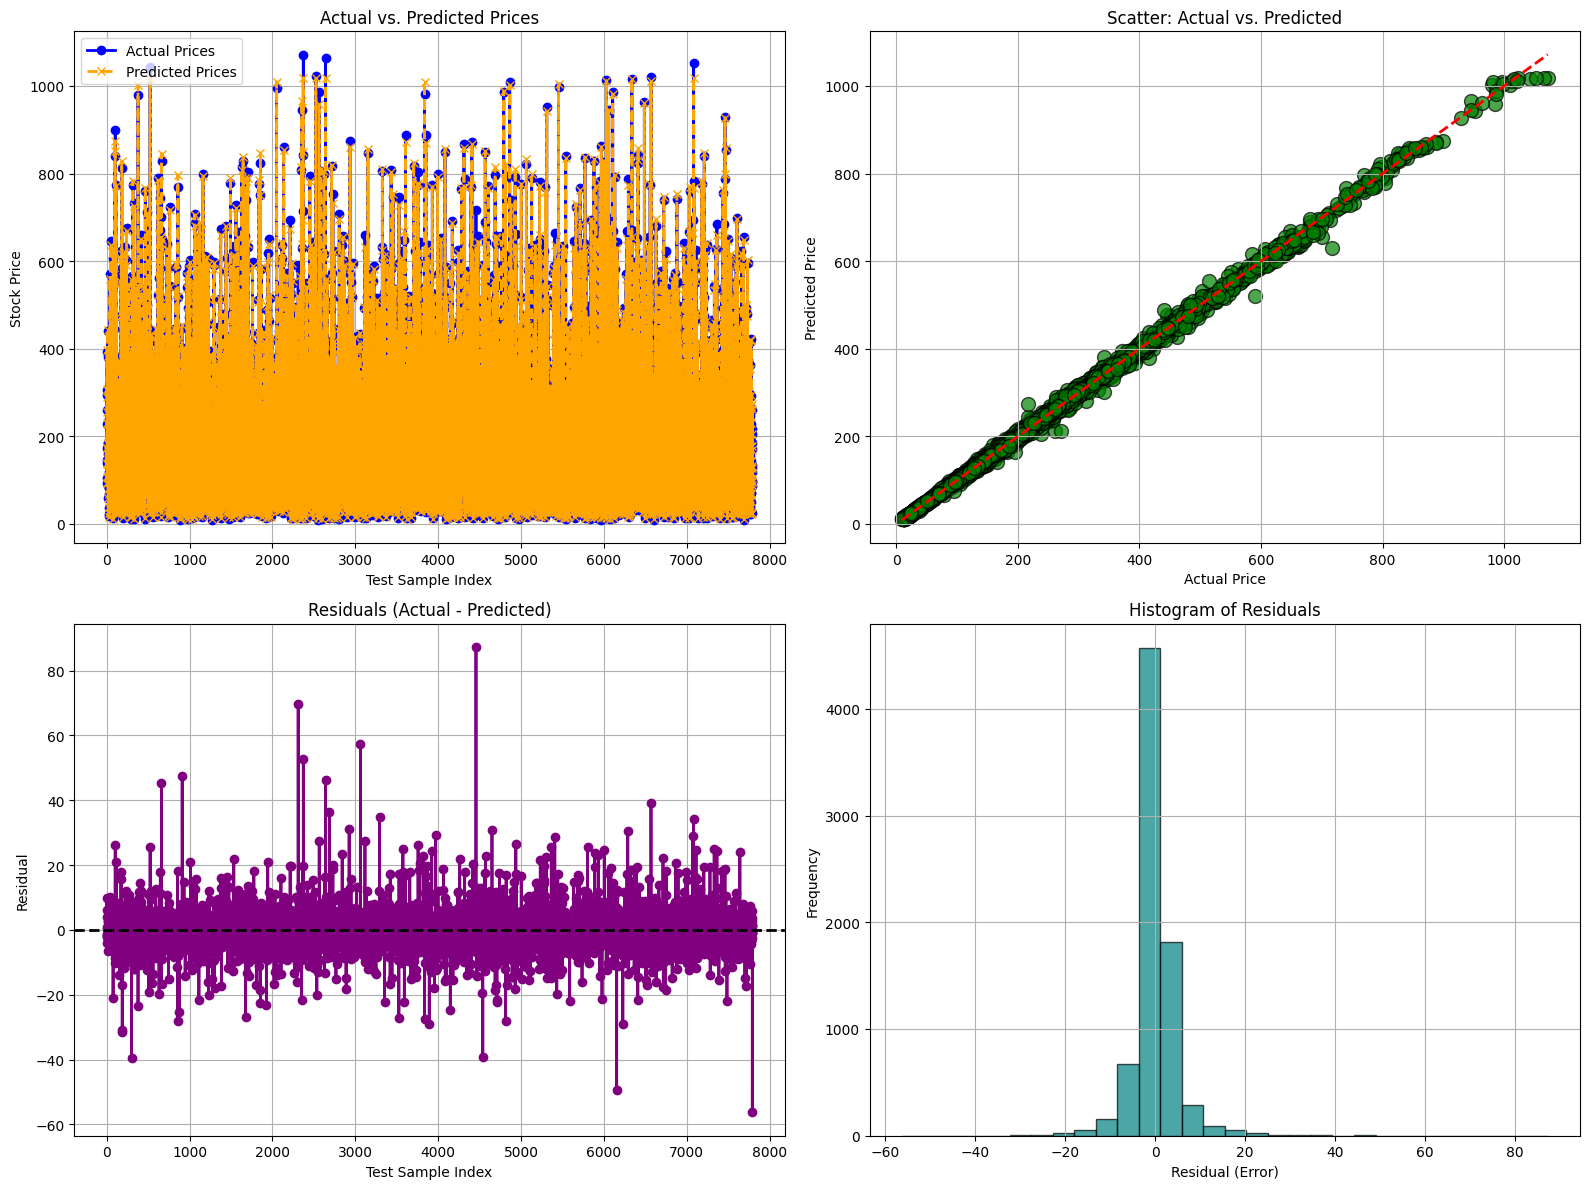

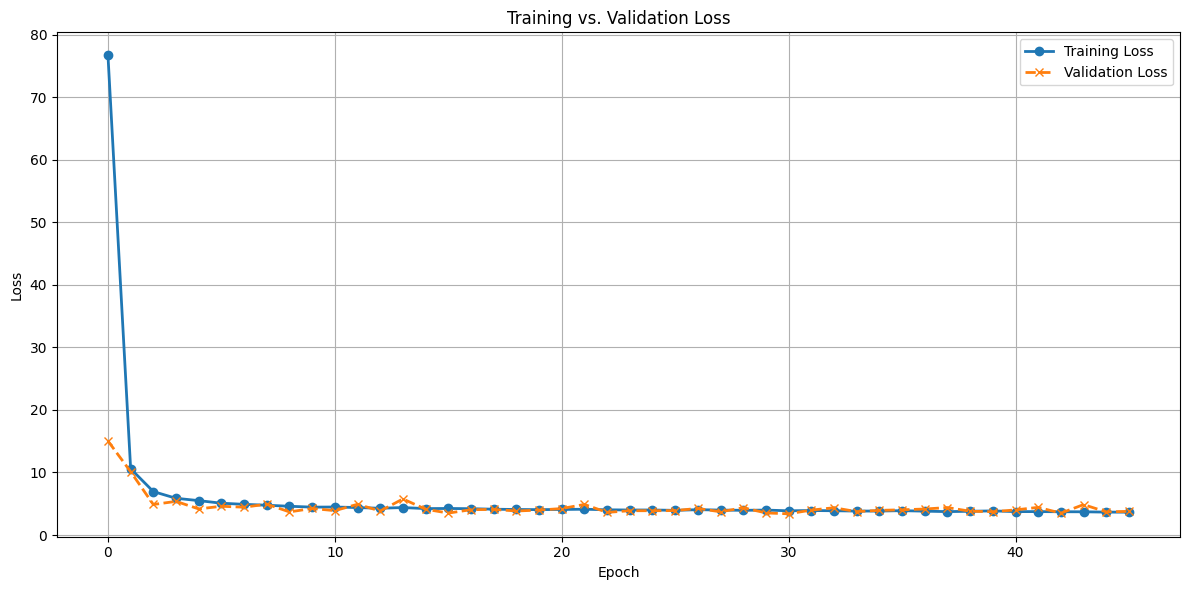

In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, max_error
import numpy as np

# --- 1. Generate Predictions ---
y_pred = model.predict(X_test).flatten()  # Ensure predictions are 1D

# --- 2. Compute Testing Metrics ---
mae_value = mean_absolute_error(y_test, y_pred)
mse_value = mean_squared_error(y_test, y_pred)
r2_value = r2_score(y_test, y_pred)
max_err_value = max_error(y_test, y_pred)

# Compute MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    # Avoid division by zero by replacing zeros with 1 (or handle differently as needed)
    return np.mean(np.abs((y_true - y_pred) / np.where(y_true == 0, 1, y_true))) * 100

mape_value = mean_absolute_percentage_error(y_test, y_pred)

print(f"Test MAE: {mae_value:.4f}")
print(f"Test MSE: {mse_value:.4f}")
print(f"Test R² Score: {r2_value:.4f}")
print(f"Test Maximum Error: {max_err_value:.4f}")
print(f"Test MAPE: {mape_value:.2f}%")

# --- 3. Create Combined Visualizations ---
# (Not using seaborn styles; using default matplotlib style)

# Create a 2x2 subplot grid
fig, axs = plt.subplots(2, 2, figsize=(16, 12))

# 3.1 Line Plot: Actual vs. Predicted Prices
axs[0, 0].plot(y_test, label="Actual Prices", color="blue", marker="o", linestyle="-", linewidth=2)
axs[0, 0].plot(y_pred, label="Predicted Prices", color="orange", marker="x", linestyle="--", linewidth=2)
axs[0, 0].set_title("Actual vs. Predicted Prices")
axs[0, 0].set_xlabel("Test Sample Index")
axs[0, 0].set_ylabel("Stock Price")
axs[0, 0].legend()
axs[0, 0].grid(True)

# 3.2 Scatter Plot: Actual vs. Predicted Prices
axs[0, 1].scatter(y_test, y_pred, color="green", alpha=0.7, edgecolor="black", s=100)
axs[0, 1].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], "r--", linewidth=2)
axs[0, 1].set_title("Scatter: Actual vs. Predicted")
axs[0, 1].set_xlabel("Actual Price")
axs[0, 1].set_ylabel("Predicted Price")
axs[0, 1].grid(True)

# 3.3 Residual Plot (Errors: Actual - Predicted)
residuals = y_test - y_pred
axs[1, 0].plot(residuals, color="purple", marker="o", linestyle="-", linewidth=2)
axs[1, 0].axhline(0, color="black", linestyle="--", linewidth=2)
axs[1, 0].set_title("Residuals (Actual - Predicted)")
axs[1, 0].set_xlabel("Test Sample Index")
axs[1, 0].set_ylabel("Residual")
axs[1, 0].grid(True)

# 3.4 Histogram of Residuals
axs[1, 1].hist(residuals, bins=30, color="teal", edgecolor="black", alpha=0.7)
axs[1, 1].set_title("Histogram of Residuals")
axs[1, 1].set_xlabel("Residual (Error)")
axs[1, 1].set_ylabel("Frequency")
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()

# --- 4. Optional: Training vs. Validation Loss Plot ---
# (Requires that you have a 'history' object returned from model.fit())
if "history" in globals():
    plt.figure(figsize=(12, 6))
    plt.plot(history.history["loss"], label="Training Loss", marker="o", linestyle="-", linewidth=2)
    plt.plot(history.history["val_loss"], label="Validation Loss", marker="x", linestyle="--", linewidth=2)
    plt.title("Training vs. Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [22]:
import numpy as np
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    median_absolute_error,
    max_error
)
import math

# -------------------------------
# 1. Overall Regression Metrics
# -------------------------------
mae_value = mean_absolute_error(y_test, y_pred)
mse_value = mean_squared_error(y_test, y_pred)
rmse_value = math.sqrt(mse_value)
r2_value = r2_score(y_test, y_pred)
medae_value = median_absolute_error(y_test, y_pred)
max_err_value = max_error(y_test, y_pred)

def mape(y_true, y_pred):
    # Replace zeros in y_true to avoid division by zero
    return np.mean(np.abs((y_true - y_pred) / np.where(y_true == 0, 1, y_true))) * 100

def smape(y_true, y_pred):
    return 100 / len(y_true) * np.sum(
        2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-8)
    )

mape_value = mape(y_test, y_pred)
smape_value = smape(y_test, y_pred)

print("Overall Regression Metrics:")
print(f"  MAE:    {mae_value:.4f}")
print(f"  MSE:    {mse_value:.4f}")
print(f"  RMSE:   {rmse_value:.4f}")
print(f"  R²:     {r2_value:.4f}")
print(f"  Median AE: {medae_value:.4f}")
print(f"  Max Error: {max_err_value:.4f}")
print(f"  MAPE:   {mape_value:.2f}%")
print(f"  sMAPE:  {smape_value:.2f}%")

# -------------------------------------
# 2. Financial and Directional Metrics
# -------------------------------------
def directional_accuracy(y_true, y_pred):
    # Compare the sign of the change between consecutive values.
    true_diff = np.diff(y_true)
    pred_diff = np.diff(y_pred)
    correct = np.sum(np.sign(true_diff) == np.sign(pred_diff))
    return correct / len(true_diff) * 100

dir_acc = directional_accuracy(y_test, y_pred)
print(f"\nDirectional Accuracy: {dir_acc:.2f}%")

def compute_returns(prices):
    return np.diff(prices) / prices[:-1]

# Compute daily returns from actual and predicted prices.
returns_actual = compute_returns(y_test)
returns_pred = compute_returns(y_pred)

def sharpe_ratio(returns, risk_free_rate=0):
    # Sharpe Ratio: (mean excess return)/(std. deviation of return)
    return np.mean(returns - risk_free_rate) / np.std(returns)

sharpe_actual = sharpe_ratio(returns_actual)
sharpe_pred = sharpe_ratio(returns_pred)
print(f"Actual Sharpe Ratio:    {sharpe_actual:.4f}")
print(f"Predicted Sharpe Ratio: {sharpe_pred:.4f}")

def max_drawdown(prices):
    prices = np.array(prices)
    cumulative_max = np.maximum.accumulate(prices)
    drawdowns = (prices - cumulative_max) / cumulative_max
    return np.min(drawdowns) * 100  # expressed as a percentage

max_dd_actual = max_drawdown(y_test)
max_dd_pred = max_drawdown(y_pred)
print(f"Actual Maximum Drawdown:    {max_dd_actual:.2f}%")
print(f"Predicted Maximum Drawdown: {max_dd_pred:.2f}%")

# -----------------------------
# 3. Segmented Evaluation
# -----------------------------
n = len(y_test)
mid = n // 2
# Temporal Segmentation: First vs. Second Half
y_test_first, y_pred_first = y_test[:mid], y_pred[:mid]
y_test_second, y_pred_second = y_test[mid:], y_pred[mid:]

print("\nTemporal Segmentation Metrics:")
print("  First Half:")
print(f"    MAE:  {mean_absolute_error(y_test_first, y_pred_first):.4f}")
print(f"    MAPE: {mape(y_test_first, y_pred_first):.2f}%")
print("  Second Half:")
print(f"    MAE:  {mean_absolute_error(y_test_second, y_pred_second):.4f}")
print(f"    MAPE: {mape(y_test_second, y_pred_second):.2f}%")

# Volatility-based Segmentation:
# Compute absolute returns as a proxy for volatility.
returns_full = np.abs(np.diff(y_test) / y_test[:-1])
vol_threshold = np.median(returns_full)  # median as threshold

# Adjust indices (returns array is one element shorter)
high_vol_indices = np.where(np.abs(returns_full) >= vol_threshold)[0] + 1
low_vol_indices  = np.where(np.abs(returns_full) < vol_threshold)[0] + 1

if high_vol_indices.size > 0:
    print("\nHigh Volatility Days Metrics:")
    print(f"  MAE:  {mean_absolute_error(y_test[high_vol_indices], y_pred[high_vol_indices]):.4f}")
    print(f"  MAPE: {mape(y_test[high_vol_indices], y_pred[high_vol_indices]):.2f}%")
if low_vol_indices.size > 0:
    print("\nLow Volatility Days Metrics:")
    print(f"  MAE:  {mean_absolute_error(y_test[low_vol_indices], y_pred[low_vol_indices]):.4f}")
    print(f"  MAPE: {mape(y_test[low_vol_indices], y_pred[low_vol_indices]):.2f}%")

# Directional Segmentation:
# Evaluate metrics separately for days when price went up vs. down.
true_diff = np.diff(y_test)
up_indices   = np.where(true_diff > 0)[0] + 1
down_indices = np.where(true_diff < 0)[0] + 1

if up_indices.size > 0:
    print("\nUpward Movement Days Metrics:")
    print(f"  MAE:  {mean_absolute_error(y_test[up_indices], y_pred[up_indices]):.4f}")
    print(f"  MAPE: {mape(y_test[up_indices], y_pred[up_indices]):.2f}%")
if down_indices.size > 0:
    print("\nDownward Movement Days Metrics:")
    print(f"  MAE:  {mean_absolute_error(y_test[down_indices], y_pred[down_indices]):.4f}")
    print(f"  MAPE: {mape(y_test[down_indices], y_pred[down_indices]):.2f}%")


Overall Regression Metrics:
  MAE:    2.9029
  MSE:    26.5946
  RMSE:   5.1570
  R²:     0.9989
  Median AE: 1.5465
  Max Error: 87.2346
  MAPE:   1.77%
  sMAPE:  1.76%

Directional Accuracy: 99.17%
Actual Sharpe Ratio:    0.3186
Predicted Sharpe Ratio: 0.3202
Actual Maximum Drawdown:    -99.12%
Predicted Maximum Drawdown: -98.93%

Temporal Segmentation Metrics:
  First Half:
    MAE:  2.8719
    MAPE: 1.74%
  Second Half:
    MAE:  2.9338
    MAPE: 1.79%

High Volatility Days Metrics:
  MAE:  3.3557
  MAPE: 1.92%

Low Volatility Days Metrics:
  MAE:  2.4505
  MAPE: 1.61%

Upward Movement Days Metrics:
  MAE:  3.9490
  MAPE: 1.50%

Downward Movement Days Metrics:
  MAE:  1.8480
  MAPE: 2.04%
